# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [27]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
from IPython.core.debugger import Tracer; debug_here = Tracer()

C:\ProgramData\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


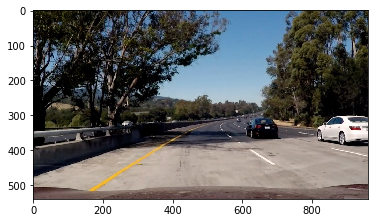

In [28]:
#reading in an image
def read_image(path):
    """Reads and returns image from the given path"""
    return mpimg.imread(path)

#printing out some stats and plotting
def read_image_and_print_dimensions(path):
    image = mpimg.imread(path)
    print('This image is:', type(image), 'with dimensions:', image.shape)
    # plt.imshow(image) 
    # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    plt.imshow(image, cmap='gray')
    return image
image = read_image_and_print_dimensions('test_images/challenge.jpg')

In [29]:
import inspect

In [30]:
import os
from itertools import chain
from copy import deepcopy

class Lane(object):
    """
    There are two lines and update them using the information we gather.
    """
    """ the interval that represents the critical slope change interval  """
    CRITICAL_SLOPE_DIFFERENCE = 0.1
    ABSOLUTE_LANE_HORIZONTAL_SLOPE = 0.4
    MAX_SLOPE_DIFFERENCE = 0.8
    MAX_DISTANCE_FROM_LINE = 20
    MEMORY_FRAMES = 10
    LEFT_LANE_LINE_TYPE = "left_line";
    RIGHT_LANE_LINE_TYPE = "right_line";
    
    # Lane lines' color will be drawed in red:
    
    COLORS = {
        'lane_color': (255,0,0),
        'region_stable': (223,228,255),
        'region_unstable': (255,148,46),
        LEFT_LANE_LINE_TYPE: (60,40,220),
        RIGHT_LANE_LINE_TYPE: (255,0,255)
    }
    THICKNESS = 5
    FIRST_FRAME_LINE_RANGES = {LEFT_LANE_LINE_TYPE: range(480), 
                               RIGHT_LANE_LINE_TYPE: range(480,960)}
    
    # A decision matrix for updating a lane line in order to keep it stable.
    # A weighted average of average lane position from memory and from the current frame.
    # 0.1 * frame position + 0.9 * avg from buffer: when the lane line is unstable.
    # 1 * frame position + 0 * memory: when the lane line is stable.
    DECISION_MATRIX = {False: [0.1,0.9], True: [1,0]}
    
    left_line = None
    right_line = None
    
    @staticmethod
    def lines_exist():
        return all([Lane.left_line, Lane.right_line])
    
    @staticmethod
    def fit_lane_line(segments):
        """
        Lines extrapolation using linear regression.
        Any order of polynomial can be used, but we limit ourselves with 1st order for now.
        """
        x, y = [], []
        for line in segments:
            if line.is_candidate:
                x_coords = list(range(line.x1, line.x2, 1))
                y_coords = list(map(line.get_y_coord, x_coords))
                x.extend(x_coords)
                y.extend(y_coords)
                
        if x != [] and not Lane.lines_exist():
            # debug_here()
            lane_line_type = segments[0].lane_line_type
            coords = np.array([[x, y] for x,y in zip(x, y)
                               if x in Lane.FIRST_FRAME_LINE_RANGES[lane_line_type]])
            x = coords[:,0]
            y = coords[:,1]
        if x != []:
            poly_coeffs = np.polyfit(x, y, 1)
            return poly_coeffs, list(zip(x, y))
        else: 
            return None, None
    
    @staticmethod
    def update_vanishing_point(left, right):
        equation = left.coeffs - right.coeffs
        x = -equation[1] / equation[0]
        y = np.poly1d(left.coeffs)(x)
        x, y = map(int, [x, y])
        left.vanishing_point = [x, y]
        right.vanishing_point = [x, y]
        
    @staticmethod    
    def update_lane_with_filtered_segments(segments):
        """
        Update lane status with a list of filtered Line instances which represent segments of the lane.
        """
        if segments is not None:
            left_segments = [segment for segment in segments if segment.lane_line_type == Lane.LEFT_LANE_LINE_TYPE]
            right_segments = [segment for segment in segments if segment.lane_line_type == Lane.RIGHT_LANE_LINE_TYPE]
            if not Lane.lines_exist():
                Lane.left_line = Lane(left_segments)
                Lane.right_line = Lane(right_segments)      
            Lane.update_vanishing_point(Lane.left_line, Lane.right_line)
            Lane.left_line.update_lane_line([l for l in left_segments if l.is_candidate])
#             debug_here()
            Lane.right_line.update_lane_line([r for r in right_segments if r.is_candidate])
        
    @staticmethod
    def clear():
        Lane.left_line = None
        Lane.right_line = None    
    
    def __init__(self, segments):

        memory_frames = Lane.MEMORY_FRAMES
        # Lane coefficients from the current image
        self.current_lane_line_coeffs, self.points = Lane.fit_lane_line(segments)
        
        if self.current_lane_line_coeffs is None: 
            raise Exception('Cannot initialize lane. No lines detected.')
        
        # Buffer for lane line smoothing
        self.buffer = np.array(memory_frames * [self.current_lane_line_coeffs])
        
        # Publicly available coefficients of lane line
        self.coeffs = self.buffer[0]
        
        # Stability flag. Set to False if the slope changes too rapidly
        self.stable = True
        
        # Hough lines which belong to this lane line
        self.segments = None
        
        # List of points which belong to this lane line. Transformed from segments
        self.points = None
        
        # Coordinates for drawing this lane line
        self.x1, self.x2, self.y1, self.y2 = 0,0,0,0
        
    @property
    def slope(self):
        """
        Slope of the lane line. Not intended for higher order polynomials.
        """
        if len(self.coeffs) > 2: 
            return Exception("You have a higher order polynomial for Lane, but you treat it as a line.")
        return self.coeffs[0]
    
    @property
    def intercept(self):
        """
        Intercept of the lane line. Not intended for higher order polynomials.
        """
        if len(self.coeffs) > 2: 
            return Exception("You have a higher order polynomial for Lane, but you treat it as a line.")
        return self.coeffs[1]
            
    def update_lane_line(self, segments):
        """
        Update line status of the lane with a list of filtered Line instances which represent segments of the lane line.
        """
        average_buffer = np.average(self.buffer, axis=0)
        self.coeffs = np.average(self.buffer, axis=0)
        self.update_current_lane_line_coeffs(segments)
        weights = Lane.DECISION_MATRIX[self.stable]
#         debug_here()
        current_buffer_coeffs = np.dot(weights, np.vstack([self.current_lane_line_coeffs, average_buffer]))
        self.buffer = np.insert(self.buffer, 0, current_buffer_coeffs, axis=0)[:-1]
        self.update_lane_line_coords()
    
    def update_current_lane_line_coeffs(self, segments):
        lane_line_coeffs, points = Lane.fit_lane_line(segments)
        if lane_line_coeffs is None:
            lane_line_coeffs = np.average(self.buffer, axis=0)
        if points is not None:
            self.points = points
        average_buffer = np.average(self.buffer, axis=0)
        buffer_slope = average_buffer[0]
        current_slope = lane_line_coeffs[0]
        self.current_lane_line_coeffs = lane_line_coeffs        
        if abs(current_slope - buffer_slope) > Lane.CRITICAL_SLOPE_DIFFERENCE:
            self.stable = False
        else: self.stable = True
            
    def update_segments_list(self, segments):
        self.segments = segments
    
    def get_x_coord(self, y):
        return int((y - self.coeffs[1]) / self.coeffs[0])
    
    def update_lane_line_coords(self):
        # Offset to distinguish lines
        visual_offset = 20
        self.y1 = image.shape[1]
        self.x1 = self.get_x_coord(self.y1)
        self.y2 = self.vanishing_point[1] + visual_offset
        self.x2 = self.get_x_coord(self.y2)

In [31]:
class Line(object):
    """
    Line: y = slope * x + intercept.
    A line can be described by its pair of coordinates (x1, y1), (x2, y2).
    To formalize a line, we need to compute its slope and intercept.
    """
    
    def __init__(self, x1, y1, x2, y2):
#         debug_here()
        if x1 > x2: (x1, y1), (x2, y2) = (x2, y2), (x1, y1)
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        self.slope = self.compute_slope()
        self.intercept = self.compute_intercept()\
        # define position of lane line, can be left_line or right_line;
        self.lane_line_type = self.find_lane_line_type()
        
        
    def __repr__(self):
        return 'Line: x1={}, y1={}, x2={}, y2={}, a={}, b={}, candidate={}, line={}'.format(
                self.x1, self.y1, self.x2, self.y2, round(self.slope,2), 
                round(self.intercept,2), self.is_candidate, self.lane_line_position)
    
    def get_coords(self):
        return (self.x1, self.y1, self.x2, self.y2)

    def get_x_coord(self, y):
        return int((y - self.intercept) / self.slope)
    
    def get_y_coord(self, x):
        return int(self.slope * x + self.intercept)
    
    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1)
    
    def compute_intercept(self):
        return self.y1 - self.slope * self.x1
    
    @property
    def is_candidate(self):
        """
        Business logic to check whether this hough line can be a candidate 
        for being a segment of a lane line.
        1. The line should not be horizontal and have a reasonable slope.
        2. The slop of line should be identical with the lane line's slope.
        3. The line should locate within the range of the lane line.
        4. The line should be below the vanishing point.
        """
        if abs(self.slope) < Lane.ABSOLUTE_LANE_HORIZONTAL_SLOPE: 
            return False
        lane_line = getattr(Lane, self.lane_line_type)
        if lane_line:
            if abs(self.slope - lane_line.coeffs[0]) > Lane.MAX_SLOPE_DIFFERENCE: return False
            if self.distance_to_lane_line > Lane.MAX_DISTANCE_FROM_LINE: return False
            if self.y2 < Lane.left_line.vanishing_point[1]: return False
        return True
    
    def find_lane_line_type(self):
        """
        Find the position of the lane line with its slope.
        """
        if self.slope < 0.0: 
            return Lane.LEFT_LANE_LINE_TYPE;
        else: 
            return Lane.RIGHT_LANE_LINE_TYPE;
        
    @property
    def distance_to_lane_line(self):
        """
        Reference https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
        """
        lane_line = getattr(Lane, self.lane_line_type)
        if lane_line is None: return None
        avg_x = (self.x2 + self.x1) / 2
        avg_y = (self.y2 + self.y1) / 2
        distance = abs(lane_line.slope * avg_x - avg_y + 
                   lane_line.intercept) / math.sqrt(lane_line.slope ** 2 + 1)
        return distance

## Helper Functions

###### Below are some helper functions to help get you started. They should look familiar from the lesson!

In [32]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

### My Own Helper Functions
Below are helper functions created myself.

####  Featured Colors and Region of Interests

In [33]:
def convert_to_opencv_hsv(*hsv):
    """
    Converting color picked in gimp to open cv hsv formart.
    """
    return (hsv[0] / 2, hsv[1] / 100 * 255, hsv[2] / 100 * 255)
ROI_VERTICES = np.array([[(50, 540), (420, 330), (590, 330), 
                      (960 - 50, 540)]], dtype=np.int32)    

# White and yellow color thresholds for lines masking.
# Optional "kernel" key is used for additional morphology transformation: opening
WHITE_LINES = { 'low_th': convert_to_opencv_hsv(0, 0, 80),
                'high_th': convert_to_opencv_hsv(359, 10, 100) }

YELLOW_LINES = { 'low_th': convert_to_opencv_hsv(35, 20, 30),
                 'high_th': convert_to_opencv_hsv(65, 100, 100),
                 'kernel': np.ones((3,3),np.uint64)}

#### Implemented Draw funcions

In [40]:

# Basic signature: draw_some_object(what_to_draw, background_image_to_draw_on, kwargs)

# Polygon vertices for the region of interest

def draw_binary_mask(binary_mask, img):
    """ Draw binary mask in black and white
    
    Keyword arguments:
    binary_mask -- hsv binary mask
    img -- the original image

    """
    if len(binary_mask.shape) != 2: 
        raise Exception('binary_mask: not a 1-channel mask. Shape: {}'.format(str(binary_mask.shape)))
    masked_image = np.zeros_like(img)
    for i in range(3): 
        masked_image[:,:,i] = binary_mask.copy()
    return masked_image

def draw_canny_edges(binary_mask, img):
    return draw_binary_mask(binary_mask, img)

def draw_filtered_lines(lines, img, color=[255, 0, 0], thickness=2):
    """
    Comsures the output of `get_filtered_hough_lines` function to draw lines on an image.
    """
    if lines is None: 
        return img
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        x1,y1,x2,y2 = line.get_coords()
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return weighted_img(line_img, img)

def draw_points(points, img, color=(255,255,0)):
    if points is None: 
        return img
    for point in points:
        cv2.circle(img, point, 2, color, -1)
    return img

def draw_lane_lines(lane_lines, img, shade_background=False):
    if shade_background:
        α = 0.8
    else:
        α = 1.
    lane_line_image = np.zeros_like(img)
    for line in lane_lines:
        line.update_lane_line_coords()
        cv2.line(lane_line_image, (line.x1, line.y1), (line.x2, line.y2), 
                    Lane.COLORS['lane_color'], Lane.THICKNESS)
    return weighted_img(lane_line_image, img, α=α, β=1.)
  
def draw_lane_region(img):
    if not Lane.lines_exist(): 
        return img
    offset_from_vanisging_point = 20
    color = Lane.COLORS['region_stable']
    
    # Polygon points of lane region
    p1 = [Lane.left_line.x1,Lane.left_line.y1]
    p2 = [Lane.left_line.get_x_coord(Lane.left_line.y2 + offset_from_vanisging_point),
                                     Lane.left_line.y2 + offset_from_vanisging_point]
    p3 = [Lane.right_line.get_x_coord(Lane.left_line.y2 + offset_from_vanisging_point),
                                      Lane.right_line.y2 + offset_from_vanisging_point]
    p4 = [Lane.right_line.x1,Lane.right_line.y1]
    
    polygon_points = np.array([p1, p2, p3, p4], np.int32).reshape((-1,1,2))
    
    if Lane.left_line.stable is False or Lane.right_line.stable is False:
        color = Lane.COLORS['region_unstable']
    
    poly_img = np.zeros_like(img)
    cv2.fillPoly(poly_img,[polygon_points], color)
    return weighted_img(img, poly_img)

def draw_image_tiles(img, snapshot1, snapshot2):
    if not Lane.lines_exist():
        return img
    image_overlay = deepcopy(img)
    image_output = deepcopy(img)
    cv2.rectangle(image_overlay, (0,0), (540,175), (253,255,254), -1)
    alpha = 0.5
    cv2.addWeighted(image_overlay, alpha, image_output, 1 - alpha,0, image_output)
    image_tiles = weighted_img(image_output, img, α=0.3, β=0.7)
    image_tiles[20:155,20:260,:] = snapshot1
    image_tiles[20:155,280:520,:] = snapshot2
    return image_tiles

def get_lane_lines_mask(hsv_image, colors):
    """
    Image binarization using selected colors, e.g. yellow and white. The result is a binary mask
    that is an union of binary masks for each color.
    """
    masks = []
    for color in colors:
        if 'low_th' in color and 'high_th' in color:
            mask = cv2.inRange(hsv_image, color['low_th'], color['high_th'])
            if 'kernel' in color:
                # Using openning morphology transformation
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, color['kernel'])
            masks.append(mask)
        else: raise Exception('High or low threshold values is not valid')
    if masks:
        return cv2.add(*masks)
    
def get_filtered_hough_lines(image, rho, theta, threshold, min_line_length, max_line_gap):
    """
    A customize implementation of a filtered hough_lines function which allows 
    Line objects initialization and line candidate filtering.
    Returns a list of Line instances which are considered segments of a lane.
    """
    hough_lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    if hough_lines is not None:
        # ref hough_line[0] reduces the dimention of ndarray hough_lines, 
        # so that we can actually retrieve the x1, y1, x2, y2 of hough lines
        init_line_obj = lambda hough_line: Line(*hough_line[0]) 
        hough_lines_iterator = map(init_line_obj, hough_lines)
        Line_candidate_filter = lambda l: l.is_candidate
        filtered_hough_lines = list(filter(Line_candidate_filter, hough_lines_iterator))
        return filtered_hough_lines
    else: 
        return None

def image_pipeline(image):
    """
     image pipeline with 3 phases:
    1. RGB mage preprocessing and noise filtering;
    2. Lane lines state update with the information gathered in preprocessing phase;
    3. Drawing updated lane lines and other objects on image.
    """

    ### Phase 1: Raw Image Preprocessing    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    binary_mask = get_lane_lines_mask(hsv_image, [WHITE_LINES, YELLOW_LINES])
    masked_image = draw_binary_mask(binary_mask, hsv_image)   
    blur_masked_image = gaussian_blur(masked_image, 5)
    blank_image = np.zeros_like(image)
    edges_mask = canny(blur_masked_image, 280, 360)
    
    # Initialization of lane line detection
    if not Lane.lines_exist():
        edges_mask = region_of_interest(edges_mask, ROI_VERTICES)    
    edges_image = draw_canny_edges(edges_mask, blank_image)
    segments = get_filtered_hough_lines(edges_mask, 1, math.pi / 180, 5, 5, 8)
    
    ### Phase 2: Lane lines state update
    
    Lane.update_lane_with_filtered_segments(segments)

    ### Phase 3: Drawing Augmented image tiles

    # Binary color selection
    binary_snapshot = np.zeros_like(image)
    binary_snapshot = draw_binary_mask(binary_mask, binary_snapshot)
    binary_snapshot = draw_filtered_lines(segments, binary_snapshot)
    binary_snapshot = cv2.resize(deepcopy(binary_snapshot), (240,135))
    
    # Canny Edge Detection
    canny_snapshot = np.zeros_like(image)
    canny_snapshot = draw_canny_edges(edges_mask, canny_snapshot)
    canny_snapshot = draw_points(Lane.left_line.points, canny_snapshot, Lane.COLORS['left_line'])
    canny_snapshot = draw_points(Lane.right_line.points, canny_snapshot, Lane.COLORS['right_line'])
    canny_snapshot = draw_lane_region(canny_snapshot)
    canny_snapshot = cv2.resize(deepcopy(canny_snapshot), (240,135))
    
    # Augmented image tiles
    image_tiles = deepcopy(image)
    image_tiles = draw_lane_lines([Lane.left_line, Lane.right_line], image_tiles, shade_background=True)
    image_tiles = draw_lane_region(image_tiles)
    image_tiles = draw_image_tiles(image_tiles, binary_snapshot,canny_snapshot)
    return image_tiles

C:\ProgramData\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


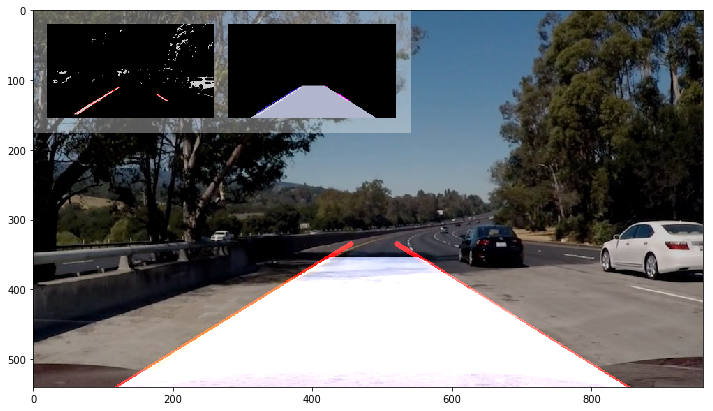

In [41]:
Lane.clear()
plt.figure(figsize=(12,8))
plt.imshow(image_pipeline(image))

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**



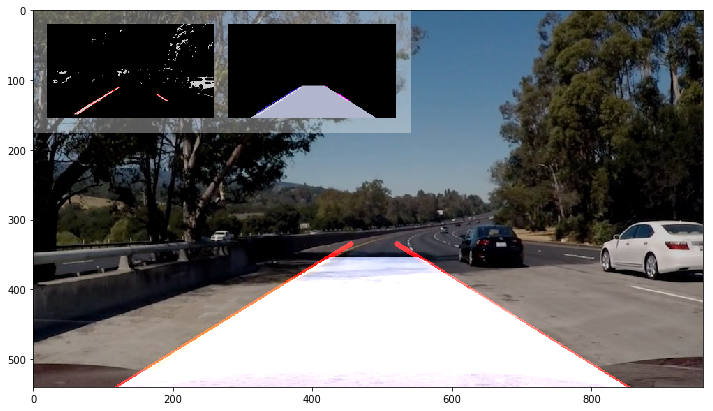

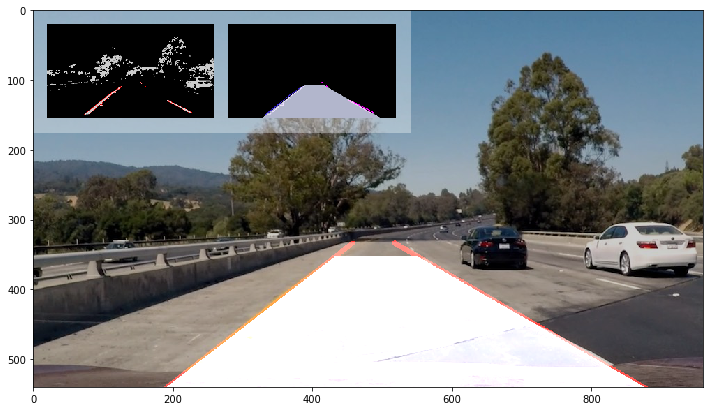

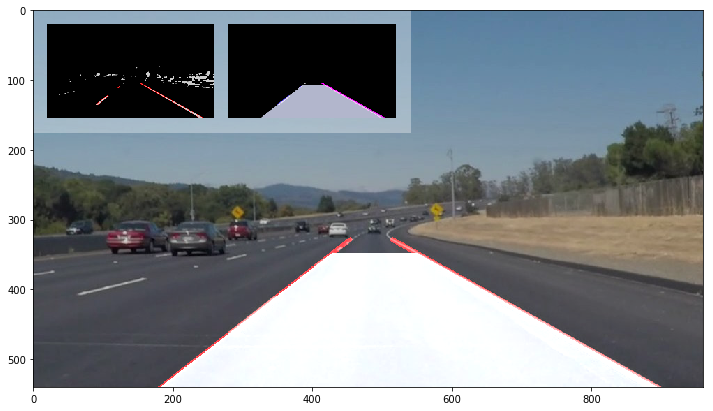

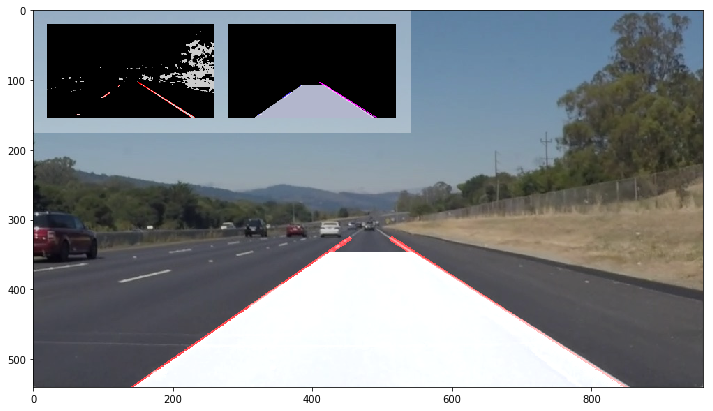

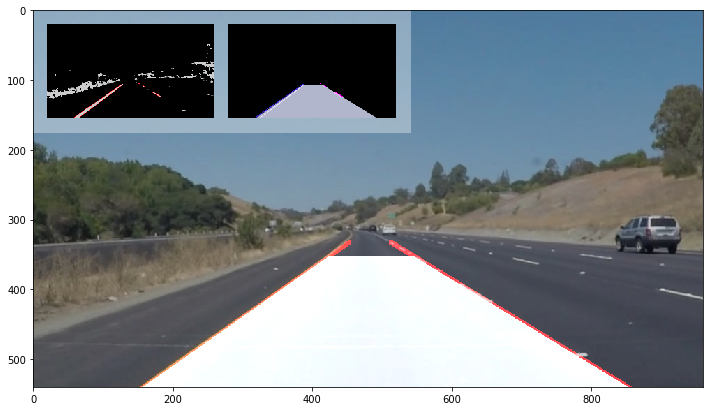

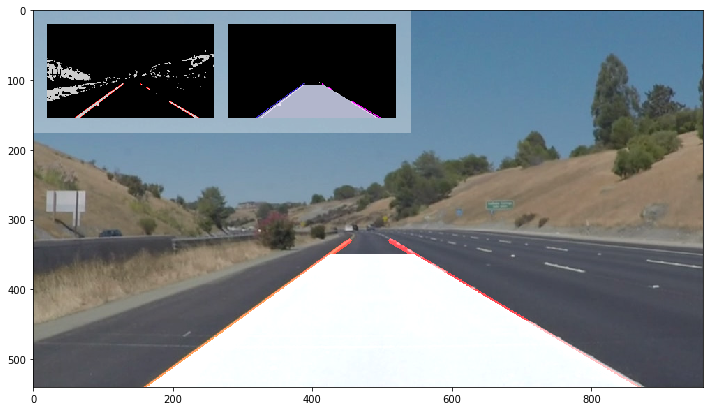

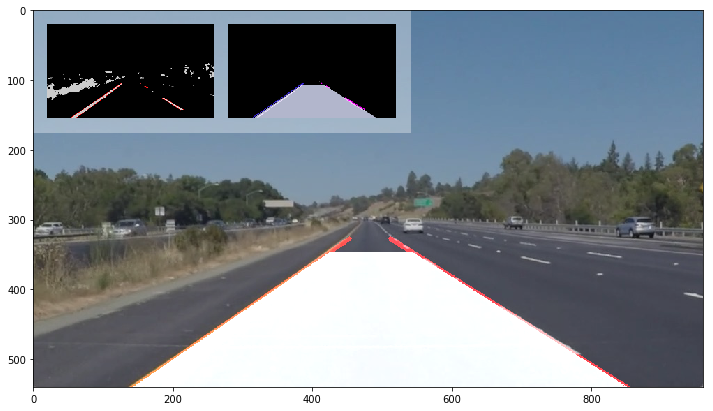

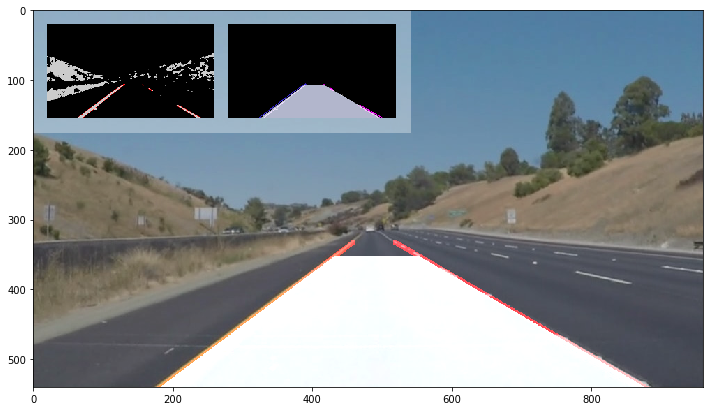

In [46]:
for img in os.listdir("test_images/"):
    if img.endswith('jpg'):
        Lane.clear()
        plt.figure(figsize=(12,8))
        image = mpimg.imread('test_images/{}'.format(img))
        plt.imshow(image_pipeline(image))

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    width = 960
    height = 540
    frame = cv2.resize(image, (960,540))
    return image_pipeline(frame)

Let's try the one with the solid white lane on the right first ...

In [47]:
Lane.clear()
white_output = 'test_videos_output/white_output.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white_output.mp4
[MoviePy] Writing video test_videos_output/white_output.mp4


100%|████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:13<00:00, 18.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white_output.mp4 

Wall time: 13.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [50]:
Lane.clear()
yellow_output = 'test_videos_output/yellow_output.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/yellow_output.mp4
[MoviePy] Writing video test_videos_output/yellow_output.mp4


100%|████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:47<00:00, 11.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow_output.mp4 

Wall time: 47.7 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [44]:
Lane.clear()
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 14.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 17.4 s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


# My Writeup

# **Finding Lane Lines on the Road** 


**Finding Lane Lines on the Road**

The goals / steps of this project are the following:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report

## Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.
Below are breakdown snapshots of my image pipline.
#### Phase 1: Image Preprocessing :
##### 1. Convert RGB image to HSV image
Reference: http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html
[image1]: ./write_up_images/HSV.png "HSV"

![alt text][image1]
#### 2. Get binary mask for yellow and  white from the HSV image
[image2]: ./write_up_images/YWBinaryMask.png "Yellow White Binary Mask"

![alt text][image2]
 #### 3. Apply binary mask to HSV image
[image3]: ./write_up_images/YWBinaryMaskToBW.png "Yellow White Binary Mask in Black White"

![alt text][image3]
#### 4. Smooth the  binary masked image
[image4]: ./write_up_images/Blur.png "Smooth Binary Mask in Black White"

![alt text][image4]
#### 5. Apply canny detection on binary masked image
[image5]: ./write_up_images/canny.png "Canny Detection on binary masked image"

![alt text][image5]
#### 6. Apply Region of Interests to canny detection
[image6]: ./write_up_images/masked_canny.png "Apply Region of Interests to canny detection"

![alt text][image6]
#### 7.Draw masked canny detection in black and white.
[image7]: ./write_up_images/BWMaskedCanny.png "Apply Region of Interests to canny detection"

![alt text][image7]
#### 8.Apply Hough Tranformation and Line filtering to masked canny detection in black and white.
Then we got the first screen shot on the image tiles
[image8]: ./write_up_images/Screenshot1.png "Hough Tranformation and Line filtering"

![alt text][image8]
#### Phase 2: Lane Line Status Detection
As the status of lane line is dynamic,  we use ```Lane``` object's static method 
```python
@staticmethod    
def update_lane_with_filtered_segments(segments):
```
to update the Lane status. Noticed that we passed ```Line``` objects segments from Phase 1 to this funtion.

First, let's take a look at ```Line``` object. Each instance of ```Line``` represents a segment of a lane line (left or right). And it can also be any random line we got from the Hough Transformation. Thus, ```Line``` object in this project is defined to filter all the lines from Hough Transformation with the consideration of if the line is a candidate for being a segment of the lines of a lane. Based on the consensus, we use the following business logic:
``` python
@property
def is_candidate(self):
    """
    Business logic to check whether this hough line can be a candidate 
    for being a segment of a lane line.
    1. The line should not be horizontal and have a reasonable slope.
    2. The slop of line should be identical with the lane line's slope.
    3. The line should locate within the range of the lane line.
    4. The line should be below the vanishing point.
```

Given the candidates we got from the above logic, we can easily get rid of fixed Region of Interests.Though there is still noise mixed in the candidates, the candidates are close enough to the lane line we are looking for. However, the candidate logic relies heavily on detecting the differece between the slope of line and the slope of the lane. This can be improved in the future.

As for ```Lane``` object, it contains two lane lines, left and right. To update the status of Lane lines, I use the candidates from ```Line.is_candidate``` as points to fit 1st level polynomial with ```numpy.polyfit```

Another important issue we need to address is the stability of lane lines. To stable the lane lines, I used two methods listed as following:

1. **Memorizing N recent states of lane**: ```Lane``` object memorize N recent states of lane and update the memory with processing a new line state of current frame.
2. **Update the lane state with weighted memory**: As there is still noise mixed in the line candidates, we might easily get a wrong line extrapolation. To address this issue, first we need to differ unstable line states from stable ones. And then treat the unstable lines with different approach. Thus, if the estimated slope of the fitted line from the current frame is far different with the average of the memory, we flag this line is unstable. And then, we create a decision matrix to decide how to use current fitted line and memory's average to extrapolate the lane. The following shows how the decision matrix can be applied to line extrapolation:
```python 
    # A decision matrix for updating a lane line in order to keep it stable.
    # A weighted average of average lane position from memory and from the current frame.
    # 0.1 * frame position + 0.9 * avg from buffer: when the lane line is unstable.
    # 1 * frame position + 0 * memory: when the lane line is stable.
    DECISION_MATRIX = {False: [0.1,0.9], True: [1,0]}
```
```Lane``` object has a flag property to indicate the line's stability from the current frame: ```self.stable```. When the lane line is stable, the flag is ```True```, and region of interest is painted in milky white. While the line is lane line is unstable, the flag is ```False```, and the region of interest is painted in orange. In the video clip, you will see orange flashing in ROI when the lane line is unstable.

[image9]: ./write_up_images/unstableLine.png "When encounter unstable lane, ROI is orange. "

![alt text][image9]
[image10]: ./write_up_images/stableLine.png "When encounter stable lane, ROI is white. "

![alt text][image10]

##### Phase 3: Drawing 
For determining if the line is a candidate for being a segment of lane line, one of the conditions is that the position of the line should be below the vanishing point of the lane lines. To locate the vanishing point, the method ```update_vanishing_point```:
```python
@staticmethod
def update_vanishing_point(left, right):
    equation = left.coeffs - right.coeffs
    x = -equation[1] / equation[0]
    y = np.poly1d(left.coeffs)(x)
    x, y = map(int, [x, y])
    left.vanishing_point = [x, y]
    right.vanishing_point = [x, y]
```
which calculates the coordinates of the point where two lane lines intersect.  Moreover, a vanishing point also helps to draw the polygon that represents the region of interest.
### 2. Identify potential shortcomings with your current pipeline
 The first shortcoming is the ROI detection. When the slope of lane changes too fast, for instances, on moutain roads, the ROI detection will fail as it relies heavily on comparing the slope difference between current frame and the average of memory. The second shortcoming is the image binariztion. When the shadow on the lane is too heavy, the lane detection fails.
 
### 3. Suggest possible improvements to your pipeline
     1. I would say ROI detection. I can be better to identify a ROI automatically withou prededined a fixed Polygon.
     2. Better image binarization using deelp learning techniques which enable lane detection in various of conditions.e.g. Snow day.
